# Импорты

In [1]:
import os
import glob
import torch
import shutil
import json
import mlflow
import albumentations as A
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.gridspec as grids
import torchvision.transforms as T
import torchvision.transforms.functional as F
import segmentation_models_pytorch as smp
from torchinfo import summary
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from mlflow.models import infer_signature

%matplotlib inline

#mlflow.set_tracking_uri("http://localhost:5000")

/home/prokofev.a@agtu.ru/Загрузки/qgis temp/Обучение моделей/learn_cycle/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Запуск MLFlow

In [2]:
ex = mlflow.set_experiment("iou_test")
#mlflow.pytorch.autolog()

2025/04/08 19:01:01 INFO mlflow.tracking.fluent: Experiment with name 'iou_test' does not exist. Creating a new experiment.


# Класс Датасета

In [ ]:
class MyDataset(Dataset):
    def __init__(self, root, transform=None, debug=False, layerNames=('one', 'two', 'ssrd', 'strd', 'e', 'u10', 'v10', 't2m', 'sst', 'sp', 'rsn', 'sd', 'lsm'), maskNames=('CT', 'CA', 'CB', 'CC', 'SA', 'SB', 'SC', 'CN', 'CD', 'FA', 'FB', 'FC', 'CF')):
        super(MyDataset, self).__init__()
        self.__root = root
        self.__transform = transform
        self.__layerNames = layerNames
        self.__maskNames = maskNames
        self.__debug = debug

        self.__image_files = glob.glob(self.__root + "/*.gpkg")
        self.__ice_types = pd.read_csv(self.__root + "/ice_types.csv", index_col=0, dtype=np.int32)

        with open('ice_types_dict.json', 'r', encoding='utf-8-sig') as f:
            ice_dict = json.load(f)
        for cat in ice_dict['fields'].keys():
            vals = [int(i) for i in ice_dict['cifer'][cat].keys()]
            for field in ice_dict['fields'][cat]:
                self.__ice_types[field] = self.__ice_types[field].map(dict(zip(vals, [i / len(vals) for i in range(0, len(vals))] )))

        print(f"Найдено {len(self.__image_files)} изображений.")
    
    def __len__(self):
        return len(self.__image_files)

    def getLayers(self):
        return self.__layerNames, self.__maskNames

    def __getitem__(self, idx):
        try:
            if self.__debug:
                print(f"чтение файла {self.__image_files[idx]}")
            data = gpd.read_file(self.__image_files[idx]).sort_values(by=['point_id'])
            if self.__debug:
                print(f"прочитан файл {self.__image_files[idx]}")

            data['ice'] = data['ice'].astype(np.int32)
            data = data.join(self.__ice_types, on='ice', how='left')

            data = data.rename(columns={"vv": "one", "hh": "one", "vh": "two", "hv": "two"})
            if self.__debug:
                print(data)

            image_channels = []
            for layer in self.__layerNames:
                image_channels.append(np.reshape(data[layer].to_numpy(dtype=np.float32), (1000, 1000), order="F"))
            image = np.stack(image_channels, axis=-1)

            mask_channels = []
            for layer in self.__maskNames:
                mask_channels.append(np.reshape(data[layer].to_numpy(dtype=np.float32), (1000, 1000), order="F"))
            mask = np.stack(mask_channels, axis=-1)

            if self.__transform:
                image = torch.cat((self.__transform[0](image[:,:,:2]), self.__transform[1](image[:,:,2:])))
                mask = self.__transform[2](mask)
        except KeyError as e:
            print(f"ошибка при чтении файла {self.__image_files[idx]}: {e}")

        return image, mask

# Расчёт mean и std (не делать)

In [4]:
dataset = MyDataset(image_root=f"{os.getcwd()}/datasets/testv2/images",
    mask_root=f"{os.getcwd()}/datasets/testv2/labels",
    transform=[T.ToTensor(), T.ToTensor()])
image_data_loader = DataLoader(
    dataset,
    batch_size=len(dataset),
    shuffle=False,
    num_workers=0)
def mean_std(loader):
  images, lebels = next(iter(loader))
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std
mean, std = mean_std(image_data_loader)
print("mean and std: \n", mean, std)

TypeError: MyDataset.__init__() got an unexpected keyword argument 'image_root'

# Больше классов трансформаций

## Нормализация объекта относительно самого себя

In [3]:
class NormalizeObject(torch.nn.Module):
    def __init__(self):
        super(NormalizeObject, self).__init__()
    
    def forward(self, obj: torch.Tensor):
        for index in range(obj.shape[0]):
            layer = obj[index].clone()
            obj[index] = (layer - layer.mean()) / layer.std()
        return obj

## Скалирование от минимума до максимума

In [4]:
class MinMaxScaler(torch.nn.Module):
    def __init__(self):
        super(MinMaxScaler, self).__init__()
    
    def forward(self, obj: torch.Tensor):
        for index in range(obj.shape[0]):
            layer = obj[index].clone()
            obj[index] = (layer - layer.min()) / (layer.max() - layer.min() + 1e-8)
        return obj

## Выравнивание гистограммы

In [5]:
class HistogramEqualizer(torch.nn.Module):
    def __init__(self, bins=256):
        super(HistogramEqualizer, self).__init__()
        self.__bins = bins
    
    def forward(self, x):
        """
        Args:
            x: Tensor shape (..., H, W) - любой размерности
        Returns:
            Equalized tensor same shape as input
        """
        
        for index in range(x.shape[0]):
            layer = x[index].clone()
            orig_shape = layer.shape
            x_flat = layer.flatten()
            
            # Вычисляем min/max если не заданы
            min_val = x_flat.min()
            max_val = x_flat.max()
            
            # Нормализуем в [0, bins-1]
            x_norm = (x_flat - min_val) * (self.__bins - 1) / (max_val - min_val + 1e-8)
            x_norm = torch.clamp(x_norm, 0, self.__bins - 1)
            
            # Вычисляем гистограмму и CDF
            hist = torch.bincount(x_norm.to(torch.long), minlength=self.__bins)
            cdf = torch.cumsum(hist, dim=0)
            cdf_normalized = (cdf - cdf.min()) / (cdf.max() - cdf.min() + 1e-8)
            
            # Применяем эквализацию
            equalized = cdf_normalized[x_norm.to(torch.long)]
            x[index] = equalized.reshape(orig_shape)
        
        return x

## Частотная фильтрация

In [6]:
class FrequencyFilter(torch.nn.Module):
    def __init__(self, filter_size=2):
        """
        Args:
            filter_size: int - абсолютный размер в пикселях
            filter_type: 'highpass' или 'lowpass'
        """
        super(FrequencyFilter, self).__init__()
        self.__filter_size = filter_size
    
    def forward(self, x):
        for index in range(x.shape[0]):
            layer = x[index].clone()
            # FFT
            fft = torch.fft.fft2(layer)
            fft_shift = torch.fft.fftshift(fft)
            
            # Создаем маску
            h, w = layer.shape
            crow, ccol = h // 2, w // 2
            mask = torch.ones((h, w), device=layer.device)
            mask[crow-self.__filter_size:crow+self.__filter_size, 
                ccol-self.__filter_size:ccol+self.__filter_size] = 0
            
            # Применяем фильтр
            filtered_fft = fft_shift * mask
            x[index] = torch.fft.ifft2(torch.fft.ifftshift(filtered_fft)).real
        
        return x

# Определение трансформаций

In [7]:
#transform = torchvision.models.get_model_weights('resnet50').IMAGENET1K_V1.transforms()
transform = [
    T.Compose([
        T.ToTensor(),
        T.CenterCrop(1000),
        #FrequencyFilter(2),
        #MinMaxScaler()
        HistogramEqualizer(bins=5000),
        #NormalizeObject()
    ]),
    T.Compose([
        T.ToTensor(),
        T.CenterCrop(1000),
        MinMaxScaler()
        #NormalizeObject()
    ]),
    T.Compose([
        T.ToTensor(),
        T.CenterCrop(1000),
        #NormalizeObject()
    ])
]

# Определение загрузчиков данных

In [8]:
dataset = MyDataset(
    root="/run/user/823426162/kio-fuse-RZzNFK/smb/user5000@10.22.31.10/storage5000/Извлеченные поля",
    transform=transform,
    debug=True
)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

Найдено 1749 изображений.


In [10]:
training_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

## Отрисовка выборки датасета

чтение файла /run/user/823426162/kio-fuse-RZzNFK/smb/user5000@10.22.31.10/storage5000/Извлеченные поля/S1B_IW_GRDH_1SDV_20210430T021033_20210430T021058_026690_033016_7221_261.gpkg
прочитан файл /run/user/823426162/kio-fuse-RZzNFK/smb/user5000@10.22.31.10/storage5000/Извлеченные поля/S1B_IW_GRDH_1SDV_20210430T021033_20210430T021058_026690_033016_7221_261.gpkg
        point_id    one  two  mwd           ssrd          strd         e  \
0              0  183.0   46  NaN  381698.176274  1.009151e+06 -0.000014   
1              1  131.0   45  NaN  381691.534746  1.009153e+06 -0.000014   
2              2   94.0   45  NaN  381684.892248  1.009155e+06 -0.000014   
3              3  110.0   44  NaN  381678.250352  1.009157e+06 -0.000014   
4              4  147.0   44  NaN  381671.609115  1.009159e+06 -0.000014   
...          ...    ...  ...  ...            ...           ...       ...   
999995    999995  137.0   36  NaN  372229.811876  1.013436e+06 -0.000012   
999996    999996  157.0   41  N

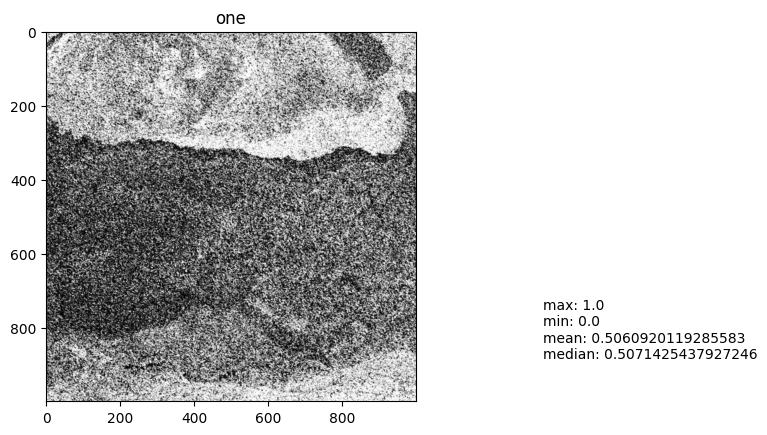

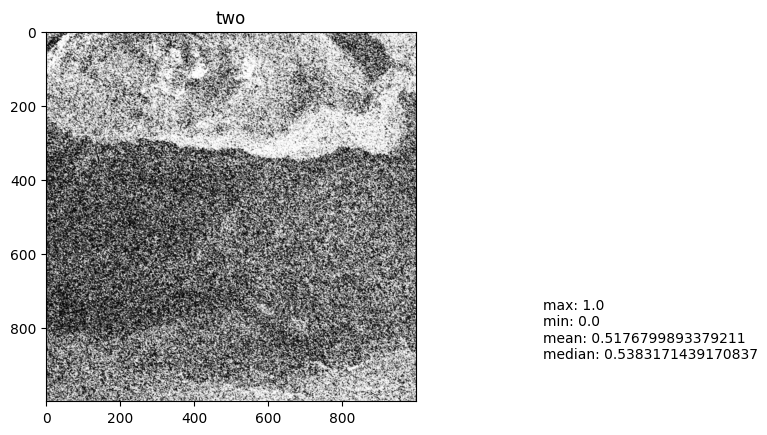

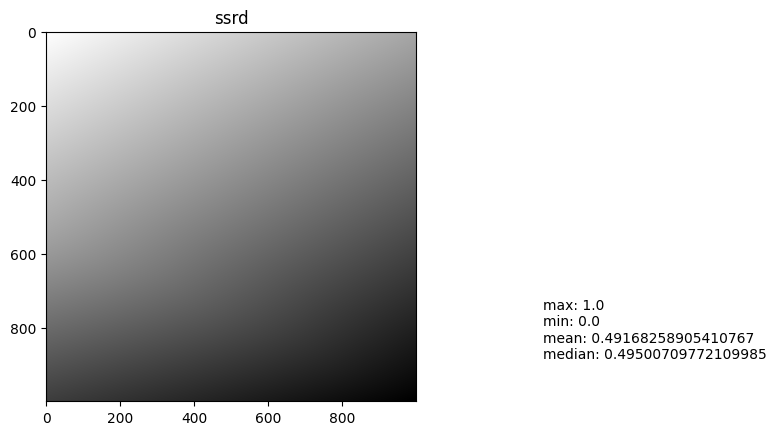

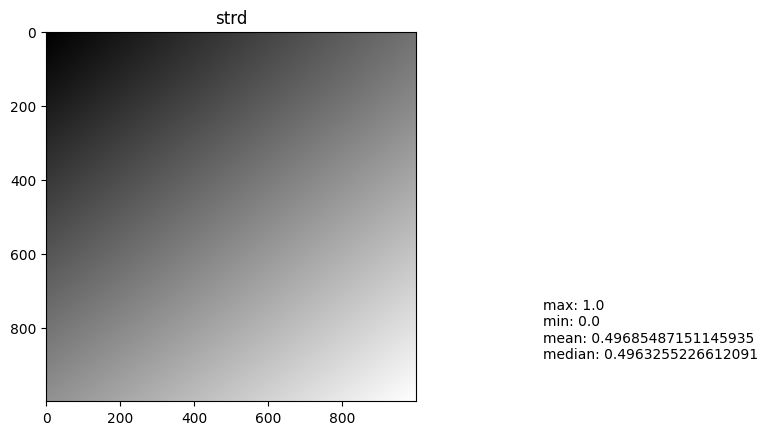

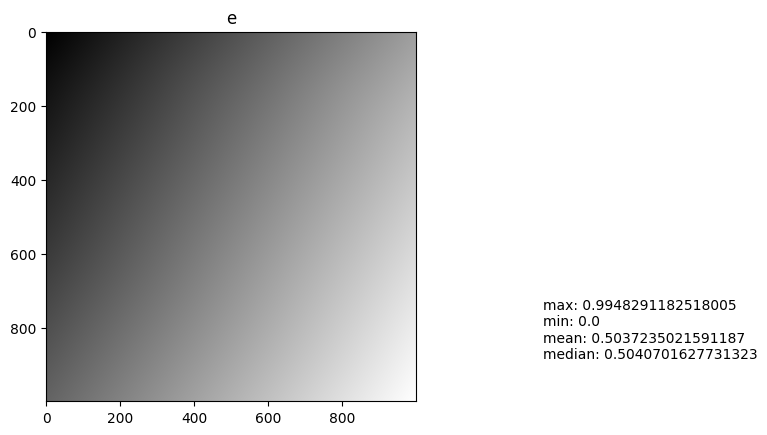

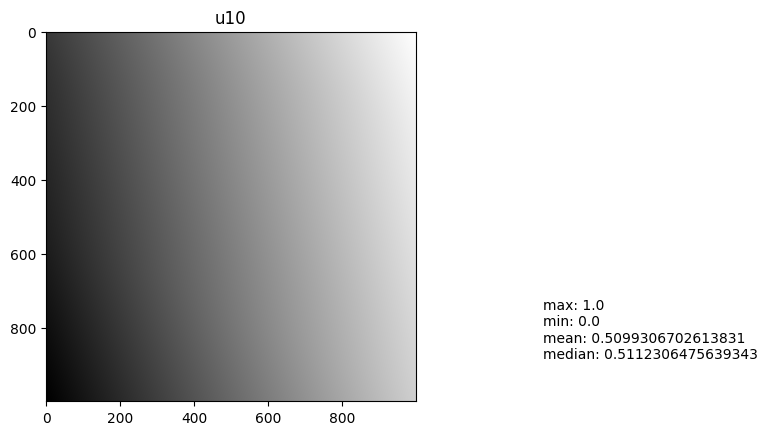

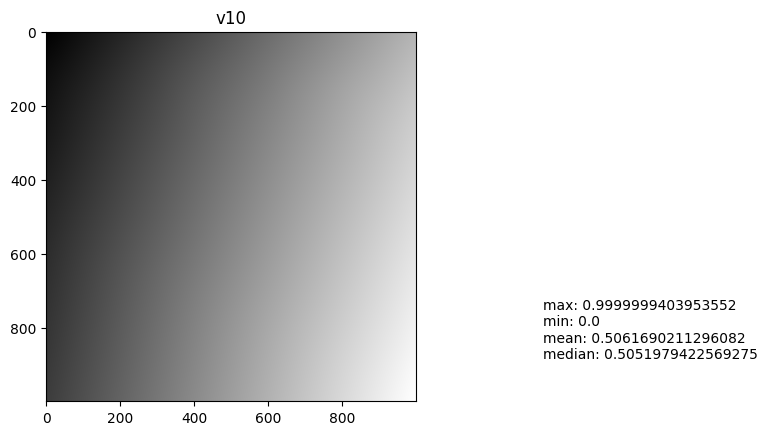

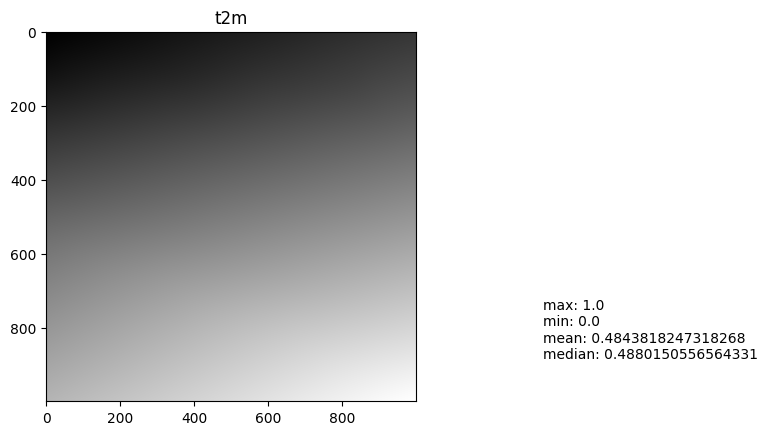

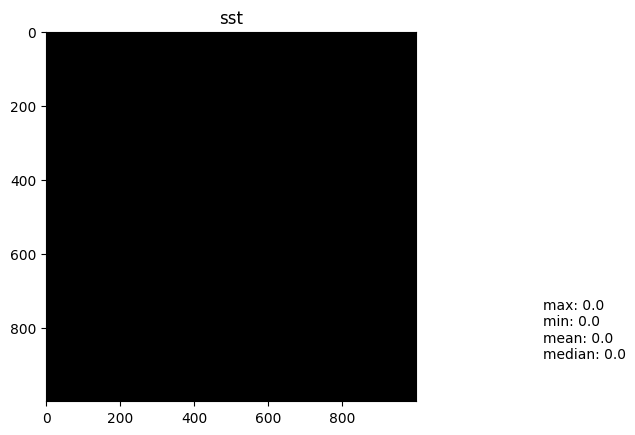

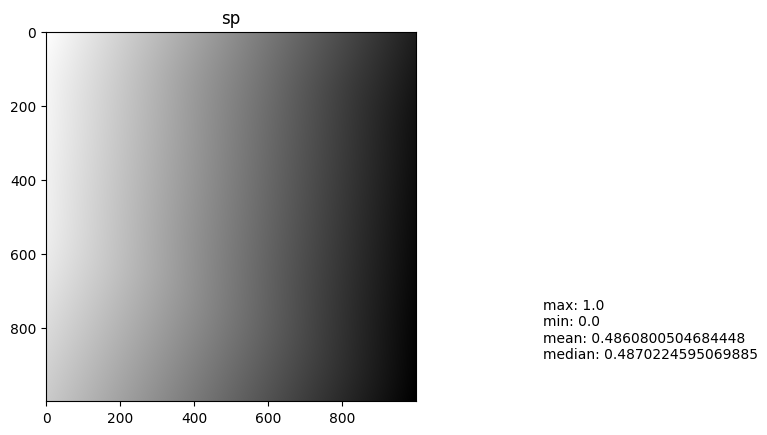

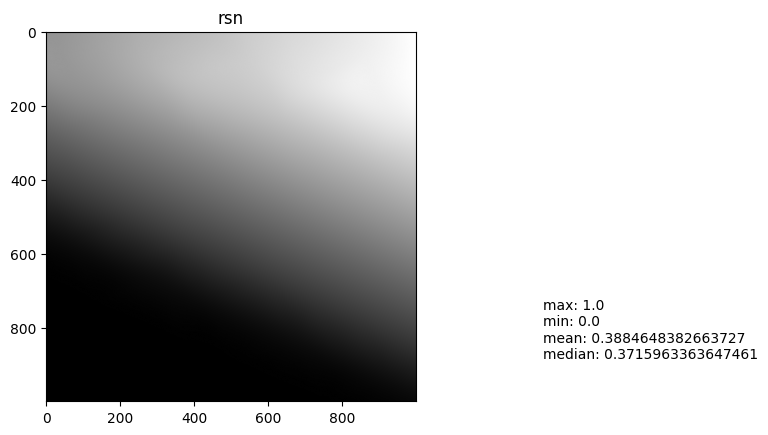

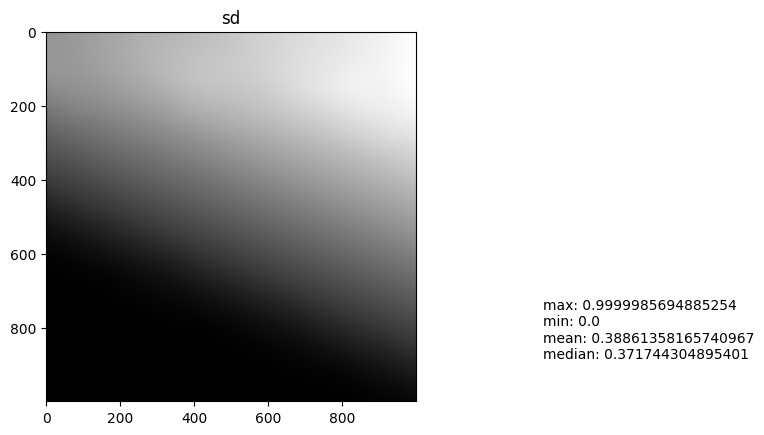

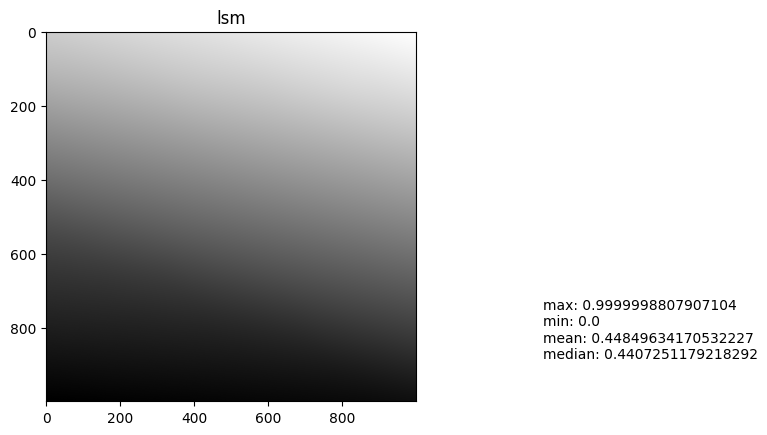

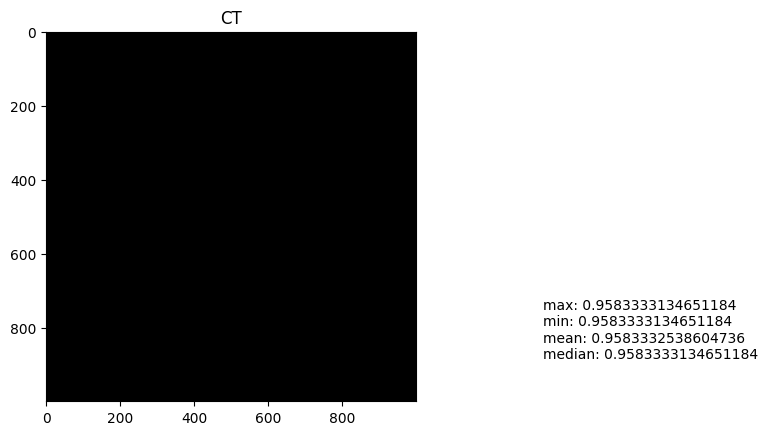

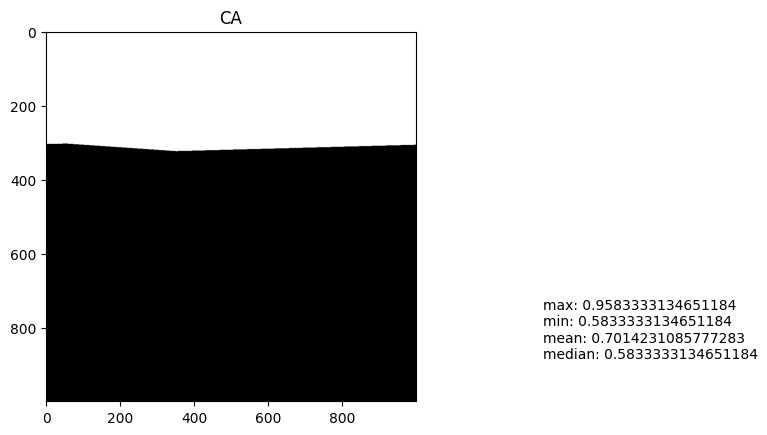

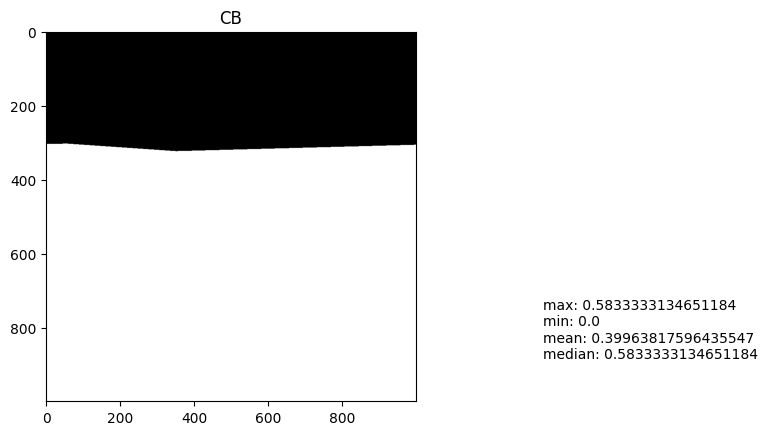

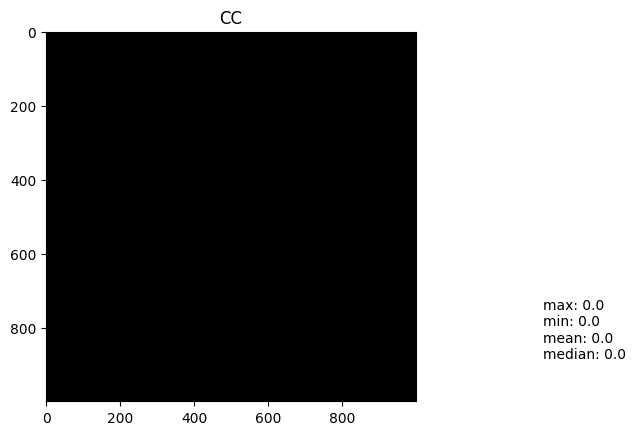

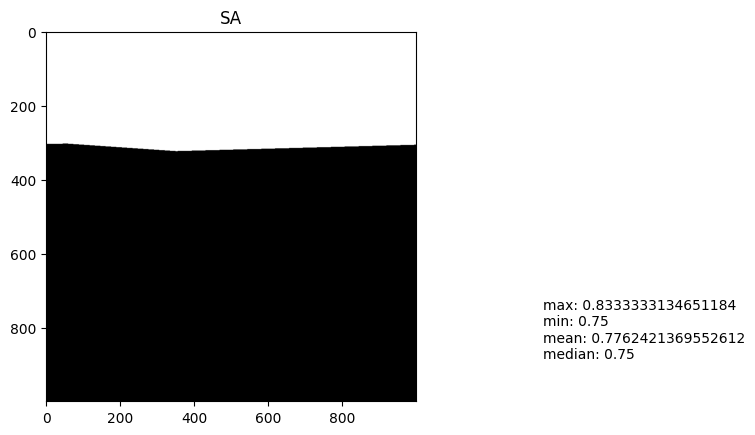

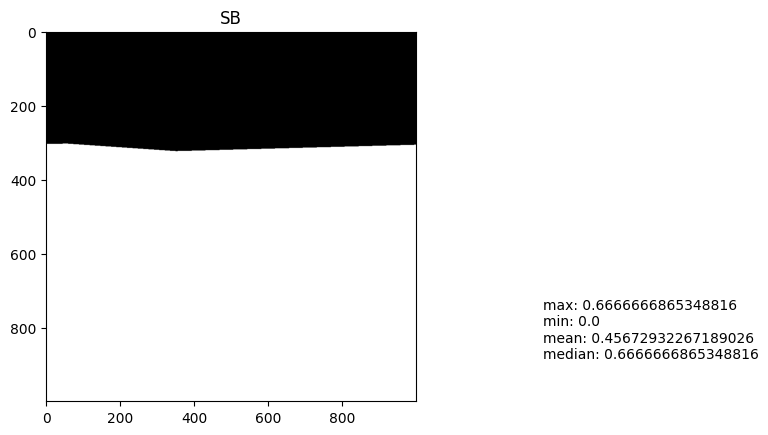

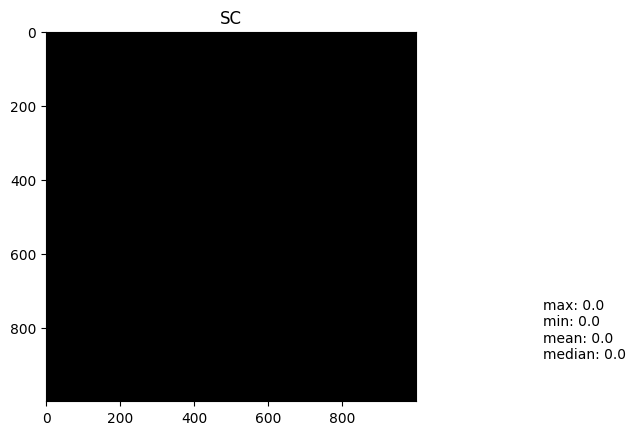

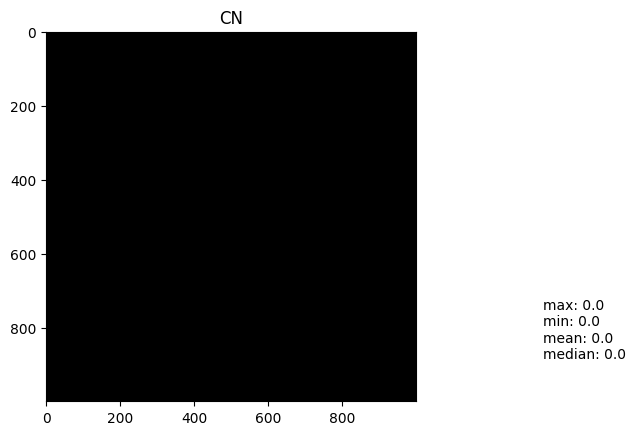

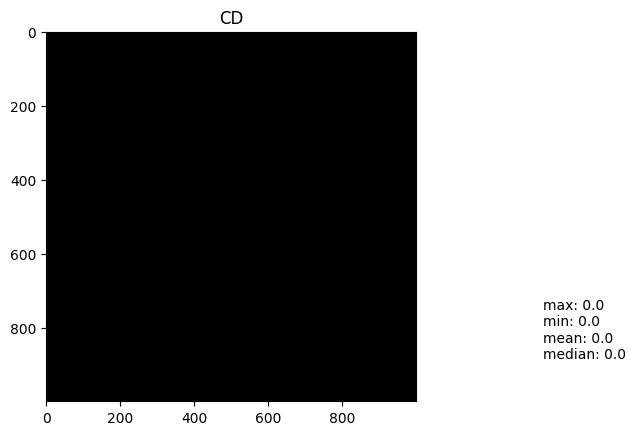

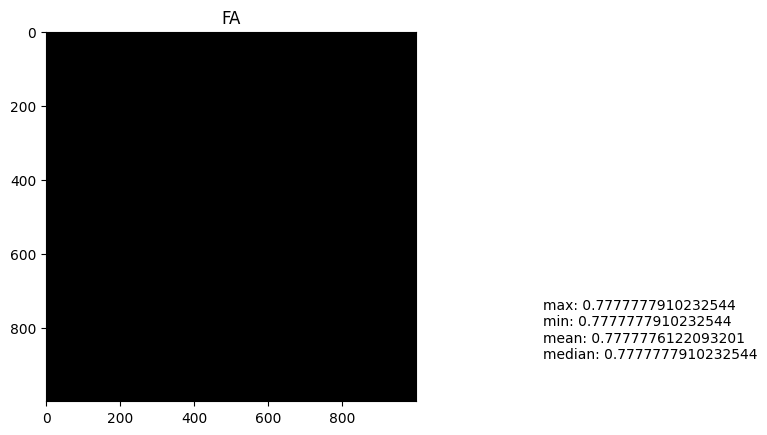

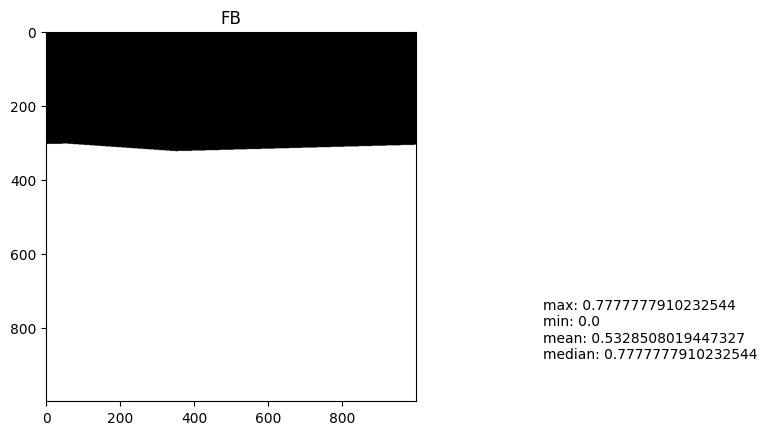

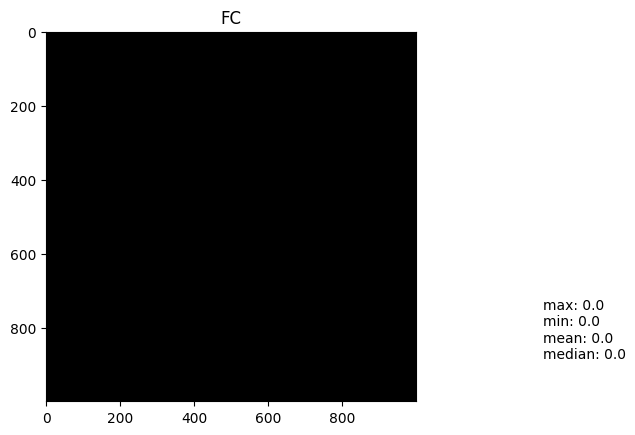

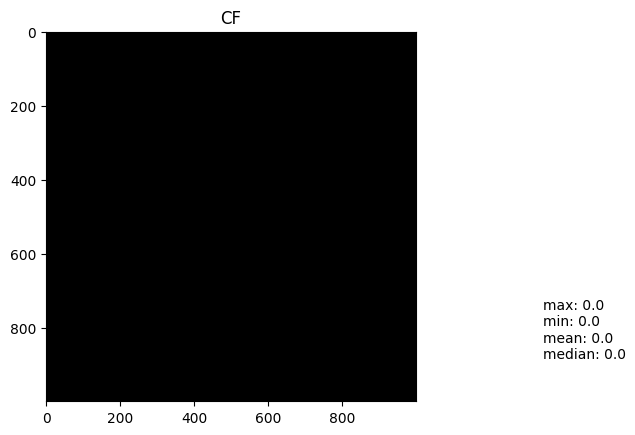

In [11]:
def desc(s: torch.Tensor):
    return "\n".join([
        "max: " + str(s.max().item()),
        "min: " + str(s.min().item()),
        "mean: " + str(s.mean().item()),
        "median: " + str(s.median().item())
    ])

layers = dataset.getLayers()
for image, mask in training_loader:
    for i in range(image.shape[1]):
        plt.imshow(image[0][i], cmap='gray')
        plt.title(layers[0][i])
        plt.figtext(1, 0.2, desc(image[0][i]))
        plt.show()
    for i in range(mask.shape[1]):
        plt.imshow(mask[0][i], cmap='gray')
        plt.title(layers[1][i])
        plt.figtext(1, 0.2, desc(mask[0][i]))
        plt.show()
    break

# Метрики

In [ ]:
def iou(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    thresholded = torch.clamp(20* (iou - 0.5), 0, 10).ceil() / 10
    return thresholded

# Функции ошибки

In [ ]:
def bce_loss(y_pred, y_real):
    loss_val = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-1 * y_pred))
    return loss_val.mean((1, 2, 3)).mean()

In [ ]:
def dice_loss(y_pred, y_real):
    num = 2 * torch.sum(y_pred * y_real)
    den = torch.sum(y_pred) + torch.sum(y_real)
    res = 1 - ((num + 1e-5) / (den + 1e-5))
    return res.mean()

In [ ]:
def focal_loss(y_pred, y_real, eps=1e-8, gamma=2):
    y_pred = torch.clip(y_pred, eps, 1 - eps)
    bce = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
    pt = torch.exp(-bce)
    focal = (1 - pt) ** gamma * bce
    return torch.mean(focal)

In [ ]:
#loss_fn = torch.nn.CrossEntropyLoss()
#loss_fn = torch.nn.BCELoss()
loss_fn = bce_loss
#loss_fn = dice_loss
#loss_fn = focal_loss

# Определение модели

In [ ]:
os.environ['TORCH_HOME'] = 'models'

model = smp.PSPNet(
    encoder_name='resnet50',
    #encoder_weights='imagenet',
    in_channels=8,
    psp_dropout=0.1,
    classes=9#,
    #activation='tanh'
)

# Оптимизатор

In [ ]:
# Optimizers specified in the torch.optim package
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.AdamW(model.parameters(), 0.0005)

# Цикл обучения

In [ ]:
EPOCHS = 5

best_vloss = 1e9
with mlflow.start_run(experiment_id=ex.experiment_id, run_name='AdamW BCE') as run:
    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch + 1))

        model.train(True)

        running_loss = 0.

        i = 0
        for (inputs, labels) in tqdm(training_loader, desc='обучение'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            i += 1
        
        avg_loss = running_loss / (i + 1)


        running_vloss = 0.0
        iou_sum = 0.
        model.eval()

        i = 0
        with torch.no_grad():
            for (vinputs, vlabels) in tqdm(validation_loader, desc='валидация'):
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                iou_sum = iou(voutputs, vlabels)
                running_vloss += vloss
                i += 1

        avg_vloss = running_vloss / (i + 1)

        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
        #mlflow.log_metric("train BCE loss", avg_loss)
        #mlflow.log_metric("val BCE loss", avg_vloss, step=epoch+1)
        mlflow.log_metrics({"train BCE loss": avg_loss, "val BCE loss": avg_vloss}, step=epoch+1)
        mlflow.log_param("iou", iou_sum / (1 + 1))

        signature = infer_signature(vinputs.numpy(), voutputs.numpy())

        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            #model_best_path = f'{os.getcwd()}/mlruns/{ex.experiment_id}/{run.info.run_id}/artifacts/best ({epoch}).pt'
            model_best_path = f"best ({epoch}).pt"
            torch.save(model.state_dict(), model_best_path)
            mlflow.pytorch.log_model(model,
                                     artifact_path=f"PSPNet best ({epoch})",
                                     signature=signature,
                                     input_example=input_example)
            #mlflow.log_artifact(model_best_path)
        #model_last_path = f'{os.getcwd()}/mlruns/{ex.experiment_id}/{run.info.run_id}/artifacts/last.pt'
        model_last_path = "last.pt"
        #torch.save(model.state_dict(), model_last_path)
        #mlflow.log_artifact(model_last_path)
        mlflow.pytorch.log_model(model,
                                 artifact_path="PSPNet last",
                                 signature=signature,
                                 input_example=input_example)

        epoch += 1

EPOCH 1:


валидация: 100%|██████████| 9/9 [00:01<00:00,  8.71it/s]


LOSS train 0.043151242485347414 valid 0.00041044803410335994
EPOCH 2:


валидация: 100%|██████████| 9/9 [00:01<00:00,  8.78it/s]


LOSS train 0.00012130497232019424 valid 4.2714689758819686e-05
EPOCH 3:


валидация: 100%|██████████| 9/9 [00:01<00:00,  7.87it/s]


LOSS train 9.603841728984828e-05 valid 4.883044775851886e-05
EPOCH 4:


валидация: 100%|██████████| 9/9 [00:01<00:00,  8.86it/s]


LOSS train 8.69719900155046e-05 valid 4.2870428438214323e-05
EPOCH 5:


валидация: 100%|██████████| 9/9 [00:01<00:00,  8.94it/s]


LOSS train 7.904867775403287e-05 valid 3.498883520983833e-05
🏃 View run AdamW BCE at: http://localhost:5000/#/experiments/318407474671426998/runs/128d54675129471ea4cb97aa48fffd4f
🧪 View experiment at: http://localhost:5000/#/experiments/318407474671426998


In [ ]:
summary(model=model,
        input_size=(4, 8, 256, 256), # make sure this is "input_size", not "input_shape"
        #col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
PSPNet (PSPNet)                                         [4, 8, 256, 256]     [4, 9, 256, 256]     --                   True
├─ResNetEncoder (encoder)                               [4, 8, 256, 256]     [4, 8, 256, 256]     22,063,104           True
│    └─Conv2d (conv1)                                   [4, 8, 256, 256]     [4, 64, 128, 128]    25,088               True
│    └─BatchNorm2d (bn1)                                [4, 64, 128, 128]    [4, 64, 128, 128]    128                  True
│    └─ReLU (relu)                                      [4, 64, 128, 128]    [4, 64, 128, 128]    --                   --
│    └─MaxPool2d (maxpool)                              [4, 64, 128, 128]    [4, 64, 64, 64]      --                   --
│    └─Sequential (layer1)                              [4, 64, 64, 64]      [4, 256, 64, 64]     --                   True
│    │ 

In [ ]:
dummy_img = torch.rand(1, 8, 256, 256)
outputs = model(dummy_img)
print(outputs[0].shape)

torch.Size([9, 256, 256])


[-3.5977864 -3.5907054 -3.5554626 ...  2.2468061  2.295901   2.32313  ]


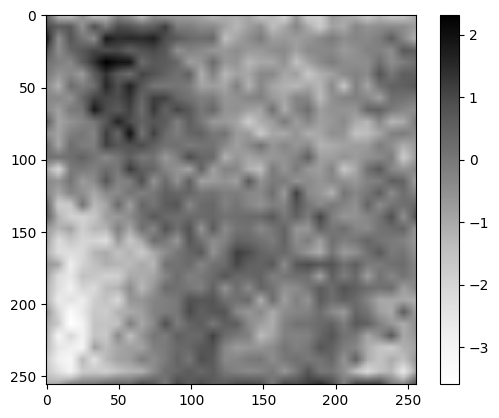

In [ ]:
im = outputs[0][0].detach().numpy()
print(np.unique(im))
plt.imshow(im, cmap='Greys')
plt.colorbar()

# Вывести пробный пакет картинок из набора

Найдено 182 изображений в подкаталоге vh.
Найдено 182 изображений.
Найдено 182 масок.


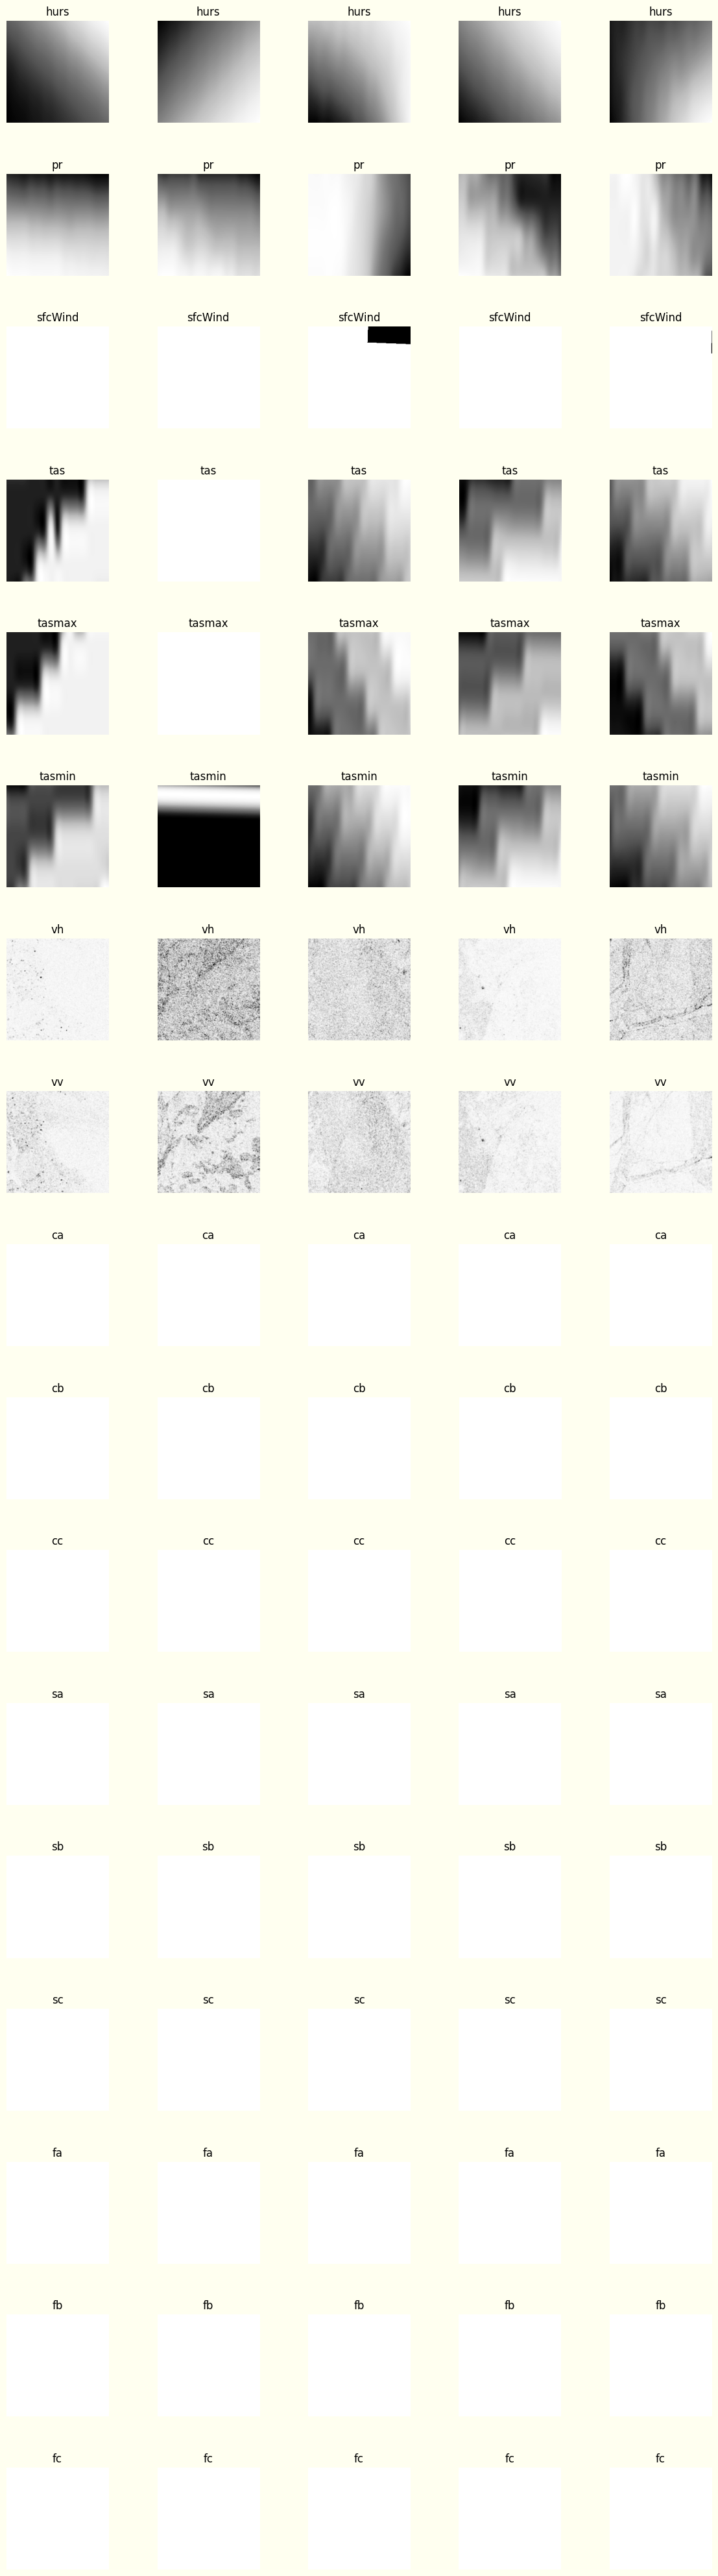

In [ ]:
dataset = MyDataset(
    image_root=f"{os.getcwd()}/datasets/dataset1/images",
    mask_root=f"{os.getcwd()}/datasets/dataset1/labels",
    transform=[T.ToTensor(), T.ToTensor()]  # Добавляем аугментацию
)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

plt.figure(figsize=(15, 51), facecolor='ivory')
gs = grids.GridSpec(17, 5)
gs.update(wspace=0, hspace=0.5)

titles = MyDataset.layerNames + MyDataset.maskNames
for i, (image, mask) in enumerate(dataloader):
    for j in range(image.shape[1]):
        ax = plt.subplot(gs[j * 5 + i])
        ax.imshow(image[0][j], cmap="Greys")
        ax.set_title(titles[0 + j])
        ax.axis('off')
        ax.set_aspect('equal')
    for j in range(mask.shape[1]):
        ax = plt.subplot(gs[(image.shape[1] + j) * 5 + i])
        ax.imshow(mask[0][j], cmap="Greys")
        ax.set_title(titles[image.shape[1] + j])
        ax.axis('off')
        ax.set_aspect('equal')
    
    if i == 4:  # Останавливаемся после 5 примеров
        break